In [406]:
## import libraries 
import pandas as pd 
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, LearningCurveDisplay, ValidationCurveDisplay
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, RocCurveDisplay
warnings.filterwarnings("ignore")

In [407]:
## importing data as dataframe 
dataset = pd.read_csv('ext_1k_TS05.csv', delimiter=',')
dataset.head()

,Unnamed: 0,Geol,Dol_den,Lin_order1,Lin_order2,RTP,BGA,eK,eU,eTh,...,NB,CE,TH,U,TREE,MGO,CAO,K2O,SIO2,Label
0,0,2.0,21.753458,8944.272461,4000.000000,195.0,175.0,2.466003,2.005496,8.283116,...,10.123745,70.459976,12.168718,3.238506,191.476334,0.921928,2.202987,2.970477,62.076954,1
1,1,5.0,0.000000,4000.000000,2000.000000,191.0,63.0,1.087193,1.456824,8.475145,...,11.927011,56.712715,12.354337,1.907947,154.653488,1.802948,4.218361,1.204851,65.349281,1
2,2,5.0,0.000000,7211.102539,2000.000000,167.0,211.0,3.638682,5.112419,40.420933,...,13.259982,107.265099,41.840858,4.400545,297.329132,2.089105,1.228896,0.925533,62.100338,1
3,3,5.0,69.865166,12649.110352,0.000000,227.0,143.0,1.781461,3.564141,18.578960,...,18.215908,69.823067,59.920433,7.381037,190.457458,1.202826,2.250504,3.130865,65.815964,1
4,4,2.0,0.000000,8246.210938,5656.854004,251.0,243.0,1.675960,1.138356,8.440859,...,6.959620,51.535969,8.711568,2.062654,154.586594,2.169107,5.281834,1.348414,58.054558,1


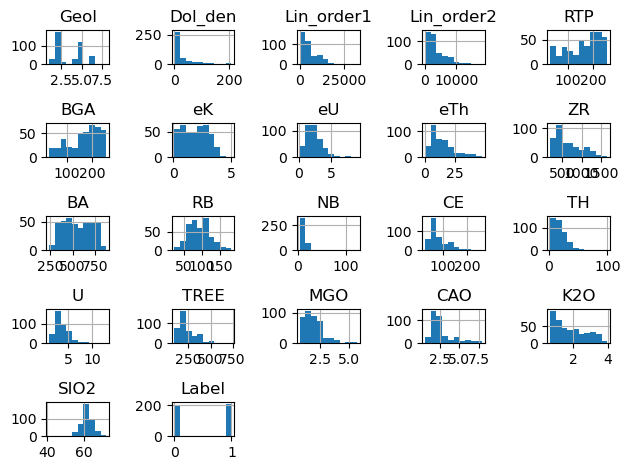

In [408]:
data_set = dataset.iloc[:,1:]
data_set.hist()
plt.tight_layout()

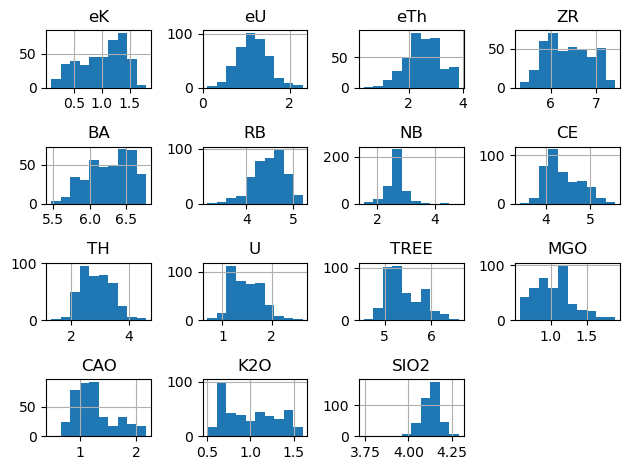

In [409]:
# Transforming geochemical variables 
dt_geochem = data_set.iloc[:,6:21]
dt_rest = data_set.iloc[:,:6]
gc_log = dt_geochem.apply(np.log1p)
gc_log.hist()
plt.tight_layout()

In [410]:
# Transformed data clubbing 
dt_tfm = pd.concat([dt_rest, gc_log], axis=1)
dt_tfm['Label'] = data_set['Label']
dt_tfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Geol        407 non-null    float64
 1   Dol_den     407 non-null    float64
 2   Lin_order1  407 non-null    float64
 3   Lin_order2  407 non-null    float64
 4   RTP         407 non-null    float64
 5   BGA         407 non-null    float64
 6   eK          407 non-null    float64
 7   eU          407 non-null    float64
 8   eTh         407 non-null    float64
 9   ZR          407 non-null    float64
 10  BA          407 non-null    float64
 11  RB          407 non-null    float64
 12  NB          407 non-null    float64
 13  CE          407 non-null    float64
 14  TH          407 non-null    float64
 15  U           407 non-null    float64
 16  TREE        407 non-null    float64
 17  MGO         407 non-null    float64
 18  CAO         407 non-null    float64
 19  K2O         407 non-null    f

In [411]:
## Train test split 
## checking the split no much imbalance 
X = dt_tfm.drop(columns='Label')
y = dt_tfm['Label']
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
print('count of xtrain', xtrain.count())
print('count of xtest', xtest.count())
print('value count of ytrain', ytrain.value_counts())
print('value count of ytest', ytest.value_counts())

count of xtrain Geol          325
Dol_den       325
Lin_order1    325
Lin_order2    325
RTP           325
BGA           325
eK            325
eU            325
eTh           325
ZR            325
BA            325
RB            325
NB            325
CE            325
TH            325
U             325
TREE          325
MGO           325
CAO           325
K2O           325
SIO2          325
dtype: int64
count of xtest Geol          82
Dol_den       82
Lin_order1    82
Lin_order2    82
RTP           82
BGA           82
eK            82
eU            82
eTh           82
ZR            82
BA            82
RB            82
NB            82
CE            82
TH            82
U             82
TREE          82
MGO           82
CAO           82
K2O           82
SIO2          82
dtype: int64
value count of ytrain Label
1    165
0    160
Name: count, dtype: int64
value count of ytest Label
1    42
0    40
Name: count, dtype: int64


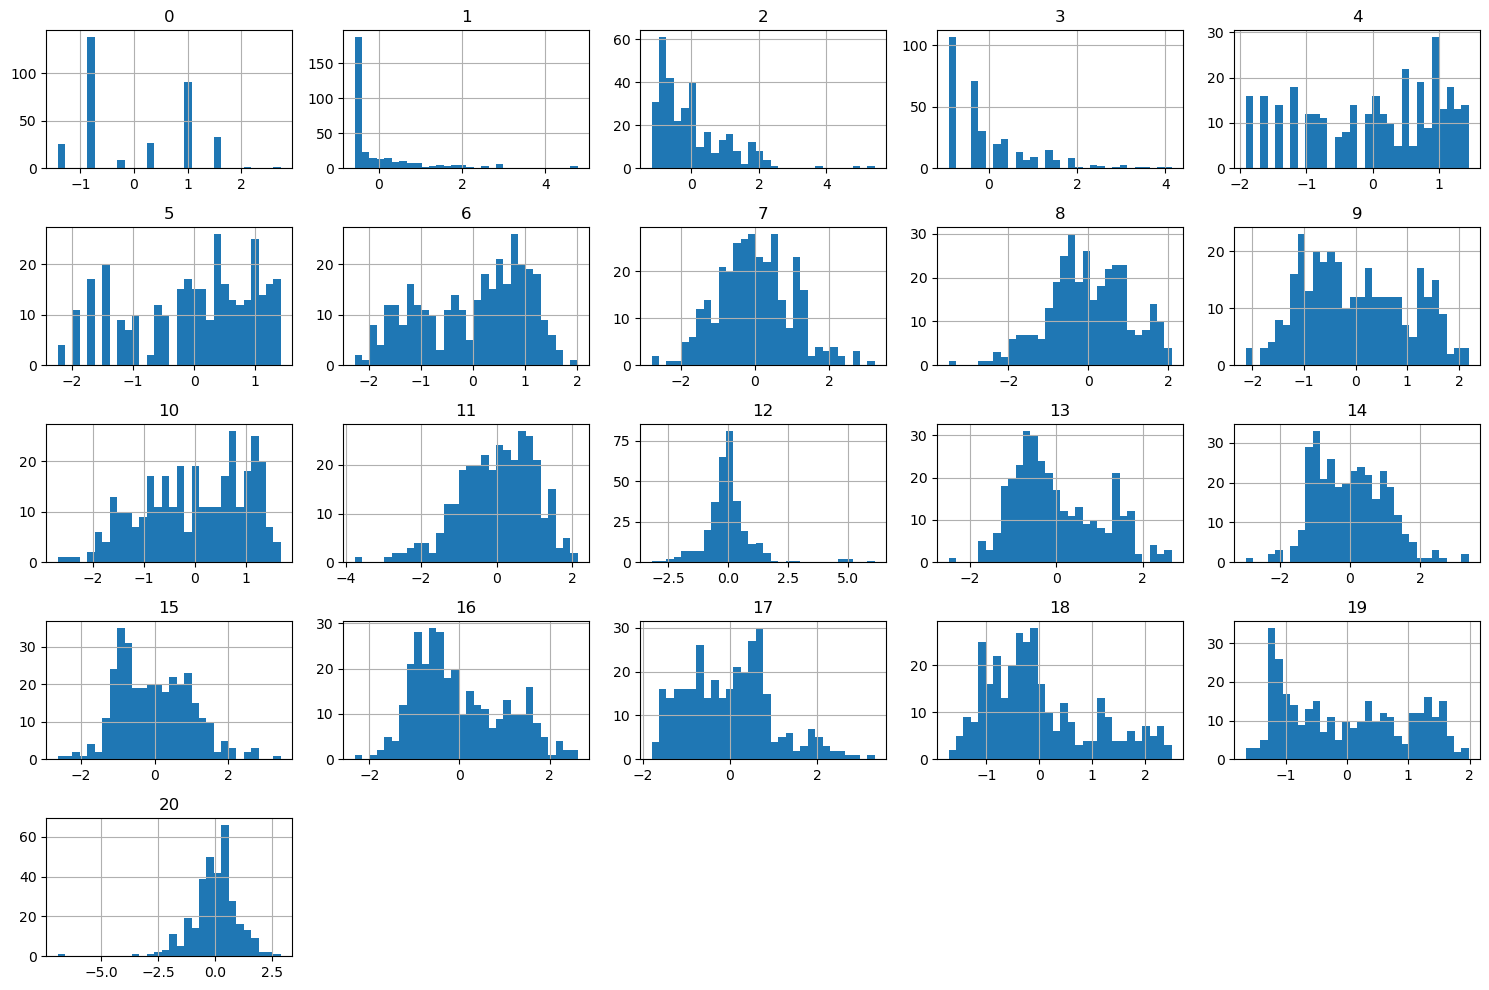

In [412]:
## strandard scaling the data 
sc = StandardScaler()
xtrain_sc = sc.fit_transform(xtrain)
xtrain_df = pd.DataFrame(xtrain_sc)
xtrain_df.hist(bins = 30, figsize=(15,10))
plt.tight_layout()

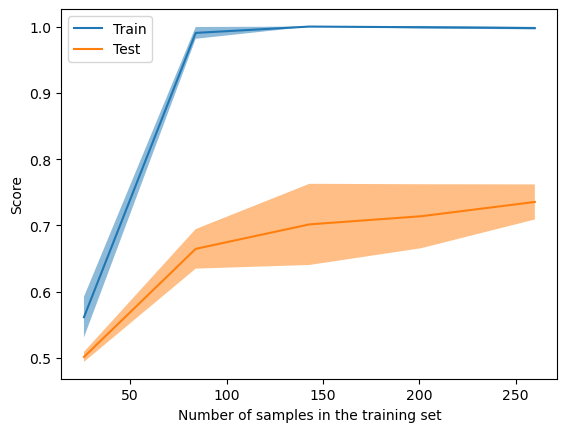

In [413]:
## Randomforest classification 
score_list = ['accuracy', 'precision', 'recall', 'f1']
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
clf = lgb.LGBMClassifier(random_state=42)
cv_results = cross_validate(clf,xtrain_sc,ytrain,cv=skf,scoring = score_list,return_train_score=True, verbose=False)
cv_pd_res = pd.DataFrame(cv_results)
LearningCurveDisplay.from_estimator(clf,xtrain_sc,ytrain,cv=skf,shuffle=True,random_state=42)

In [414]:
cv_pd_res

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.066034,0.024021,0.769231,0.996154,0.800000,0.992481,0.727273,1.000000,0.761905,0.996226
1,0.067659,0.032840,0.692308,0.996154,0.658537,0.992481,0.818182,1.000000,0.729730,0.996226
2,0.065287,0.024948,0.738462,1.000000,0.690476,1.000000,0.878788,1.000000,0.773333,1.000000
3,0.067323,0.025081,0.753846,1.000000,0.757576,1.000000,0.757576,1.000000,0.757576,1.000000
4,0.071142,0.028153,0.723077,0.996154,0.741935,1.000000,0.696970,0.992424,0.718750,0.996198


In [415]:
## Hyper_parmaeter tuning of the RaRandomForestClassifier
score_list = ['accuracy', 'precision', 'recall', 'f1']
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
clf2 =lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=500, max_depth= 5, reg_alpha=10, colsample_bytree= 0.3, class_weight='balanced', random_state=42, verbose = -1)
cv2_results = cross_validate(clf2,xtrain_sc,ytrain,cv=skf,scoring = score_list,return_train_score=True)
cv_pd_res2 = pd.DataFrame(cv2_results)

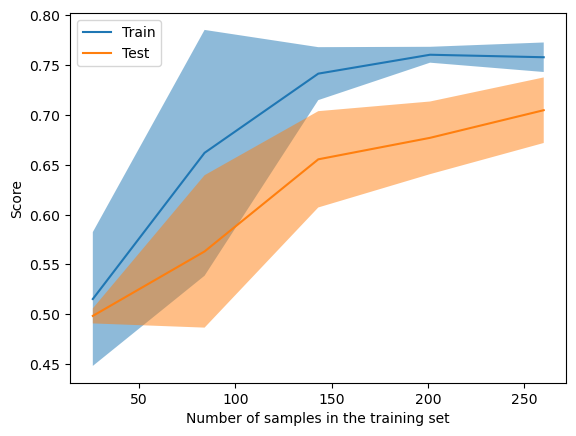

In [416]:
LearningCurveDisplay.from_estimator(clf2,xtrain_sc,ytrain,cv=skf,shuffle=True,random_state=42)

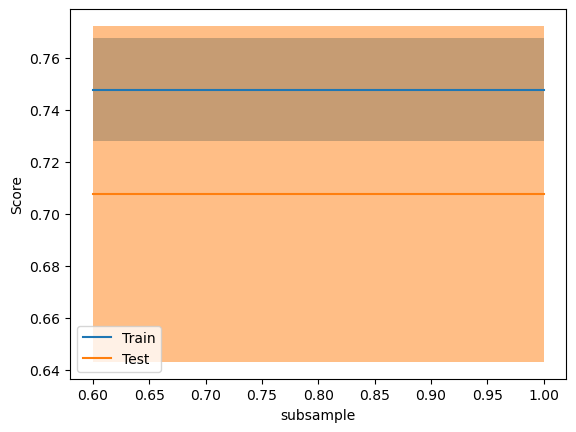

In [417]:
max_D =[0.6, 0.7, 0.8, 0.9, 1.0]
ValidationCurveDisplay.from_estimator(clf2,xtrain_sc,ytrain,param_name='subsample', param_range= max_D )

In [418]:
# results of the tuned model for random set; Class label noise is hindering ~70% accuracy 
val_mean = cv_pd_res2.mean()
val_std = cv_pd_res2.std()
val_results = pd.DataFrame()
val_results['mean'] = val_mean
val_results['std'] = val_std
val_results

,mean,std
fit_time,0.068317,0.003161
score_time,0.025286,0.002031
test_accuracy,0.704615,0.036730
train_accuracy,0.757692,0.016543
test_precision,0.712175,0.058468
train_precision,0.762076,0.019479
test_recall,0.715152,0.069763
train_recall,0.760606,0.025466
test_f1,0.710391,0.033815
train_f1,0.761110,0.016878


              precision    recall  f1-score   support

           0       0.76      0.55      0.64        40
           1       0.66      0.83      0.74        42

    accuracy                           0.70        82
   macro avg       0.71      0.69      0.69        82
weighted avg       0.71      0.70      0.69        82



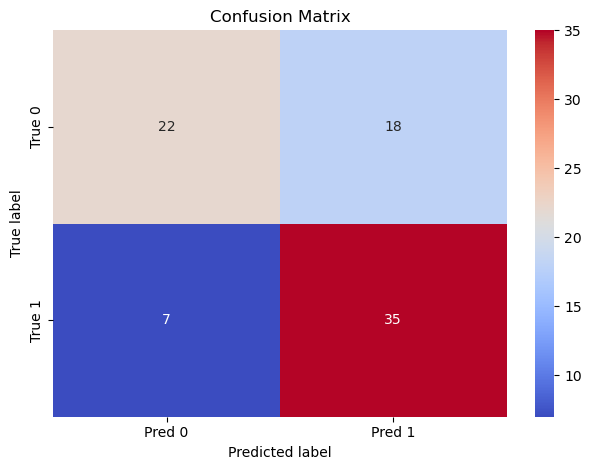

In [419]:
## Fitting the tuned model for training data and checking its prediction for test set 
clf_fit = clf2.fit(xtrain_sc,ytrain)
xtest_sc = sc.transform(xtest)
test_pred = clf2.predict(xtest_sc)
print(classification_report(y_true=ytest, y_pred=test_pred))
cm = confusion_matrix(y_true=ytest, y_pred=test_pred, labels=[0,1])
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", 
            xticklabels=["Pred 0","Pred 1"], 
            yticklabels=["True 0","True 1"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

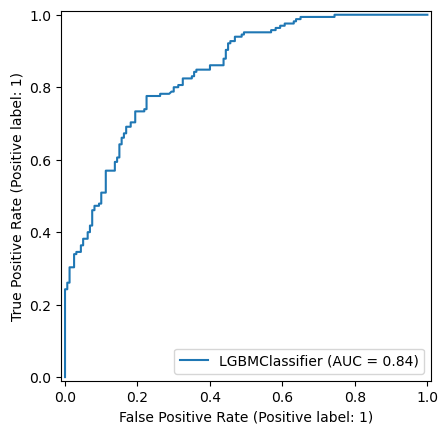

In [420]:
RocCurveDisplay.from_estimator(clf2,xtrain_sc,ytrain)

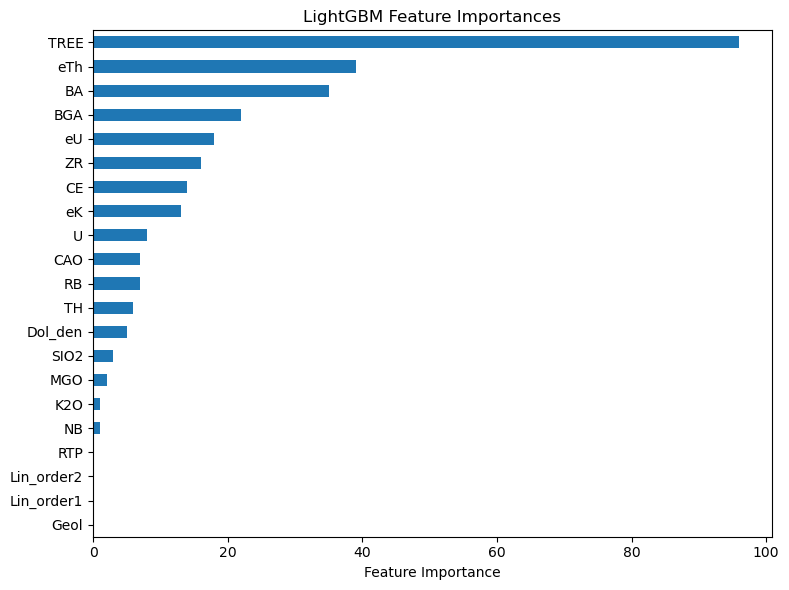

In [421]:
# Get feature importances (default: split/gain depending on LightGBM version)
importances = clf_fit.feature_importances_  # By default: 'split', can be changed via booster API

# Create Series with feature names
feat_imp = pd.Series(importances, index=dt_tfm.columns[:-1])  # exclude label column
feat_imp = feat_imp.sort_values(ascending=True)  # for horizontal bar plot

# Plot
plt.figure(figsize=(8, 6))
feat_imp.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()

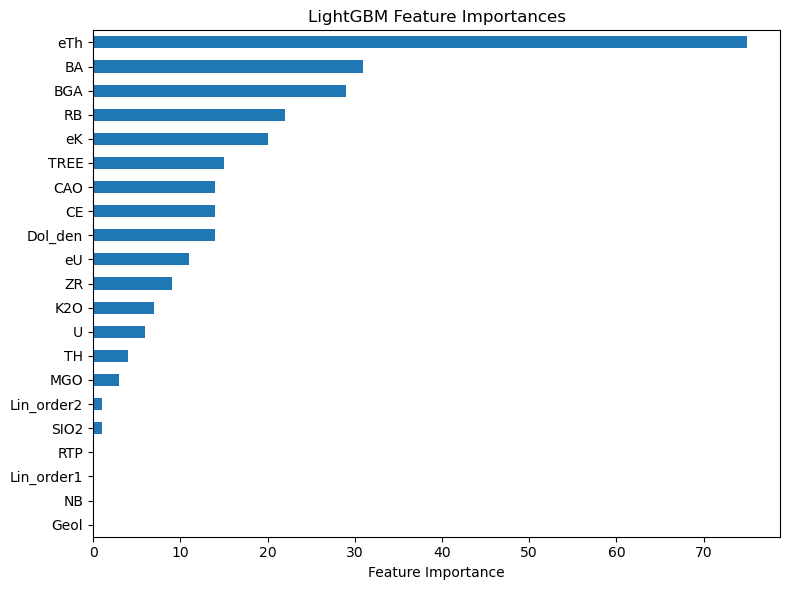

In [422]:
### Fitting model for all data 
X_sc = sc.transform(X)
clf_all = clf2.fit(X_sc,y)
importances_all = clf_all.feature_importances_

# Create Series with feature names
feat_imp = pd.Series(importances_all, index=dt_tfm.columns[:-1])  # exclude label column
feat_imp = feat_imp.sort_values(ascending=True)  # for horizontal bar plot

# Plot
plt.figure(figsize=(8, 6))
feat_imp.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()

In [423]:
### fitting model predictions for data cube 
bandset = pd.read_csv('data_cube_ext.csv', delimiter=',')
b_set = bandset.iloc[:,1:]
b_geochem = b_set.iloc[:,6:21]
b_rest = b_set.iloc[:,:6]
log_geochem = b_geochem.apply(np.log1p)
# Transformed data clubbing 
b_final = pd.concat([b_rest, log_geochem], axis=1)
b_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10434 entries, 0 to 10433
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Geol        10434 non-null  float64
 1   Dol_den     10434 non-null  float64
 2   Lin_order1  10434 non-null  float64
 3   Lin_order2  10434 non-null  float64
 4   RTP         10434 non-null  float64
 5   BGA         10434 non-null  float64
 6   eK          10434 non-null  float64
 7   eU          10434 non-null  float64
 8   eTh         10434 non-null  float64
 9   ZR          10434 non-null  float64
 10  BA          10434 non-null  float64
 11  RB          10434 non-null  float64
 12  NB          10434 non-null  float64
 13  CE          10434 non-null  float64
 14  TH          10434 non-null  float64
 15  U           10434 non-null  float64
 16  TREE        10434 non-null  float64
 17  MGO         10434 non-null  float64
 18  CAO         10434 non-null  float64
 19  K2O         10434 non-nul

In [424]:
### Predictions using clf_all
b_sc = sc.transform(b_final)
RF_model = clf_all.predict(b_sc)

In [425]:
import rasterio
height = 111
width = 94

# 1. Read the base raster’s metadata
with rasterio.open('Base_data_cube_21.tif') as src:
    meta = src.meta.copy()
    height = src.height
    width = src.width

# 2. Suppose `preds` is your 1D int array of length height*width.
#    First, reshape it:
pred_map = RF_model.reshape((height, width))

# 3. Decide on a valid integer nodata value (e.g. -9999).
#    If your pred_map has NaNs (float), convert them to -9999 now:
if np.issubdtype(pred_map.dtype, np.floating):
    mask = np.isnan(pred_map)
    pred_map = pred_map.astype(np.int64)       # cast to integer
    pred_map[mask] = -9999

# 4. Update the metadata:
meta.update({
    'count': 1,
    'dtype': 'int32',   # or 'int32', whichever you prefer
    'nodata': -9999
})

# 5. Write out your new single-band GeoTIFF
with rasterio.open('TS05_M_lgb_1k_predicted_map.tif', 'w', **meta) as dst:
    dst.write(pred_map, 1)

print("Saved 'predicted_map.tif' with nodata=-9999 and dtype=int64.")


Saved 'predicted_map.tif' with nodata=-9999 and dtype=int64.


In [426]:
# Predict class probabilities using your classifier
RF = clf_all.predict_proba(b_sc)
RF_prob = RF[:, 1]  # Probability of class 1

# Read base raster metadata
with rasterio.open('Base_data_cube_21.tif') as src:
    meta = src.meta.copy()
    height = src.height
    width = src.width

# Reshape the 1D prediction array to raster shape
pred_map = RF_prob.reshape((height, width))

# Optional: handle NaNs (though not usually present in RF_model)
if np.isnan(pred_map).any():
    pred_map = np.where(np.isnan(pred_map), -9999, pred_map)
    dtype = 'float32'
    nodata_val = -9999
else:
    dtype = 'float32'
    nodata_val = None  # Or keep existing src.meta['nodata']

# Update metadata for a single-band float raster
meta.update({
    'count': 1,
    'dtype': dtype,
    'nodata': nodata_val
})

# Write out the prediction map
with rasterio.open('TS05_M_lgb_one_cls_predicted_map.tif', 'w', **meta) as dst:
    dst.write(pred_map.astype(dtype), 1)

print("Saved 'TS05_M_XG_one_cls_predicted_map.tif'.")


Saved 'TS05_M_XG_one_cls_predicted_map.tif'.


In [427]:
xtest_sc.shape

(82, 21)